# 前処理（Preprocess）

データセットの読み込みに加えて，Hugging Face Datasetsの他の主な目標として，多様な前処理機能を提供することにあります．
これにより，様々な機械学習フレームワークで学習するのに適切な形式にデータセットを変換することができます．

データセットを前処理する方法には様々なものがあり，あなたの特定のデータセットに依存しています．
ときには列名を別のものに変える必要があるでしょうし，ネストされたフィールドを平坦化する必要があるかもしれません．
Hugging Face Datasetsは，これらの変換を行うための多くの方法を提供します．
ほとんど全ての前処理，データセットのモダリティに依存しますが，は以下のようなものがあります：
- テキストのトークナイズ
- オーディオデータのリサンプリング
- 画像データセットの変形

前処理の最後のステップは通常，あなたの機械学習フレームワークが入力として期待する形式と互換性のある形式にデータセットを変換することです．

このチュートリアルでは，Hugging Face Transformers ライブラリを利用します．

## テキストのトークナイズ

モデルは生のテキストを処理することができないので，テキストを数字の列に変換する必要があります．
トークナイゼーション(Tokenization)は，テキストを*トークン(Token)*と呼ばれる個々の単語に分割することで，これを行う方法です．

> Hugging Face コースの第2章の Tokenizers セクションを確認し，トークナイゼーションやその様々なアルゴリズムについて学習してください．

**1.** rotten_tomatoesデータセットと，事前学習済みの`BERT`モデルに対応するトークナイザの読み込みからはじめます．
事前学習モデルと同じトークナイザを利用することは，テキストを同じように分割するという観点から重要です．


In [1]:
from transformers import AutoTokenizer
from datasets import load_dataset

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
dataset = load_dataset("rotten_tomatoes", split="train")

**2.** トークナイザをデータセットの最初の行の`text`列に対して実行してみます:

In [2]:
tokenizer(dataset[0]["text"])

{'input_ids': [101, 1996, 2600, 2003, 16036, 2000, 2022, 1996, 7398, 2301, 1005, 1055, 2047, 1000, 16608, 1000, 1998, 2008, 2002, 1005, 1055, 2183, 2000, 2191, 1037, 17624, 2130, 3618, 2084, 7779, 29058, 8625, 13327, 1010, 3744, 1011, 18856, 19513, 3158, 5477, 4168, 2030, 7112, 16562, 2140, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

トークナイザは以下の3つの要素を辞書にして返します:
- `input_ids`: テキストの中のトークンを表す数値
- `token_type_ids`: 複数のシーケンスがある場合に，トークンがどのシーケンスに属しているかを示す数値
- `attention_mask`: モデルが無視すべきトークンを示す数値
これらの数値が実際のモデルの入力ととして利用されます．

**3.** データ全体を最も高速にトークナイズするには，`map()`関数を利用します．
この関数は，個々の例に適用するのではなく，バッチ化された例にトークナイザを適用することで処理を高速化します．
`batched=True`を指定することで，`map()`関数はデータセットをバッチ化します:

In [3]:
def tokenization(example):
    return tokenizer(example["text"])

dataset = dataset.map(tokenization, batched=True)

**4.** 機械学習フレームワークに合ったデータセット形式に変換します．

`set_format()`関数を使ってPyTorchの形式に変換します．

In [4]:
dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
dataset.format['type']

'torch'

**5.** データセットは準備完了です．あなたの機械学習フレームワークで学習をすることができます！

## オーディオデータのリサンプリング

オーディオ入力は，テキストデータと同様，離散的なデータポイントに分割する必要があります．
これは*サンプリング（sampling）*と呼ばれます．
サンプリングレート（サンプリング周波数）は，1秒当たりどれだけの音声信号が取得されるかを表します．
これから使うデータセットを，事前学習モデルで使われたデータと同じサンプリング周波数にすることは重要です．
もしサンプリング周波数が異なると，事前学習モデルの性能は低下します（モデルはサンプリング周波数の違いを自動的に認識しません．）

**1.** `MInDS-14`データセット，`Audio`特徴量クラス，および事前学習された`Wav2Vec2`モデルに対応する特徴抽出器を読み込みます．

In [6]:
from transformers import AutoFeatureExtractor
from datasets import load_dataset, Audio

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")
dataset = load_dataset("PolyAI/minds14", "en-US", split="train")

/home/fujie/.conda/envs/py311/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


**2.** データセットの最初の行を読み込みます．データセットの`audio`列を呼び出すと，自動的にデコードされ，リサンプリングされます．

In [7]:
dataset[0]["audio"]

{'path': '/home/fujie/.cache/huggingface/datasets/downloads/extracted/727c238ff56827207fa183e263914211df387082d5c9e015991ad43c9cc5ab82/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
 'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
         0.        ,  0.        ]),
 'sampling_rate': 8000}

**3.** データセットカードは非常に便利です．データセットに関する多くの情報を提供してくれます．
MInDS-14のデータセットカードを見ると，サンプリング周波数が8kHzであることがわかります．
同様にモデルカードから多くの詳細を得ることができます．
Wav2Vec2のモデルカードによると，このモデルは16kHzのサンプリング周波数のオーディオで事前学習されています．
このことから，データセットのサンプリング周波数を16kHzにアップサンプリングする必要があることがわかります．

`cast_column()`関数を使い，`Audio`特徴クラスに`sampling_rate`パラメタを指定することで，音声信号をアップサインプリングします．
そのあと`audio`列を呼び出すと，デコードされ，16kHzにリサンプリングされています．

In [10]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))
dataset[0]["audio"]

{'path': '/home/fujie/.cache/huggingface/datasets/downloads/extracted/727c238ff56827207fa183e263914211df387082d5c9e015991ad43c9cc5ab82/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
 'array': array([ 4.26710950e-05,  2.16939103e-04,  2.02089201e-04, ...,
         5.04053813e-05,  9.80958121e-07, -3.13585741e-05]),
 'sampling_rate': 16000}

**4.** `map()`関数を使ってデータセット全体をリサンプリングします．
この関数は，個々の例に適用するのではなく，バッチ化された例にリサンプリングを適用することで処理を高速化します．
このとき，`batched=True`を指定することで，`map()`関数はデータセットをバッチ化します:

In [11]:
def process_function(example):
    audio_arrays = [x["array"] for x in example["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=16_000,
        truncation=True,
    )
    return inputs

dataset = dataset.map(process_function, batched=True)

Map:   0%|          | 0/563 [00:00<?, ? examples/s]

**5.** データセットは準備完了です．あなたの機械学習フレームワークで学習をすることができます！

## データ拡張の適用（Apply data augmentations）

画像データセットに対するもっとも一般的な前処理は*データ拡張（data augmentation）*です．
データ拡張とは，データの意味を変えずに画像にランダムなバリエーションを加えることです．
例えば，画像の色の特性を変化させたり，画像をランダムに切り出したりすることです．
好みのデータ拡張ライブラリを利用することができますし，Hugging Face Datasetsはデータ拡張を適用するのを手助けできます．

**1.** `Beans`データセット，`Image`特徴量クラス，および事前学習された`ViT`モデルに対応する特徴抽出器を読み込みます．

In [1]:
from transformers import AutoFeatureExtractor
from datasets import load_dataset, Image

feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
dataset = load_dataset("beans", split="train")

/home/fujie/.conda/envs/py311/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/fujie/.conda/envs/py311/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


**2.** データセットの最初の行をインデキシングします．
データセットの`image`列を呼び出すと，ベースとなる`PIL`オブジェクトが自動的に画像としてデコードされます．

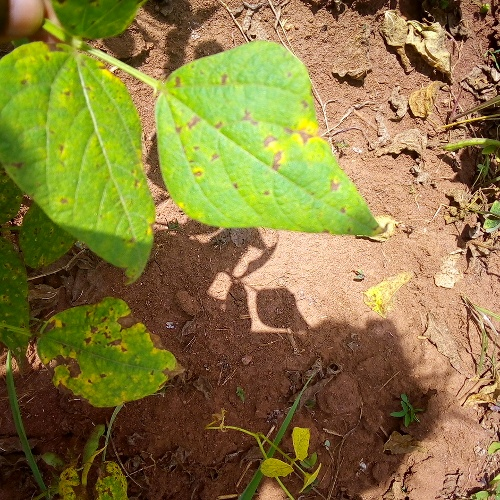

In [2]:
dataset[0]["image"]

ほとんどの画像モデルはRGBモードの画像を期待します．
Beans画像はすでにRGBモードですが，もしあなたのデータセットが異なるモードである場合，
`cast_column()`関数を使ってRGBにすることができます:

In [3]:
dataset = dataset.cast_column("image", Image(mode="RGB"))

**3.** これで，画像に適当な変換を加えることができます．
TorchVisionで提供されている[様々な変換](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)を確認して，試してみたいものを一つ選んでください．
この例では，ランダムに画像を回転させる変換を適用してみます:

In [4]:
from torchvision.transforms import RandomRotation

rotate = RandomRotation(degrees=(0, 90))
def transforms(examples):
    examples["pixel_values"] = [rotate(image) for image in examples["image"]]
    return examples

**4.** `set_transform()`関数を使うことで，オンザフライで変換を適用することができます．
`pixel_values`列を呼び出すと，変換が適用され，画像はランダムに回転します．

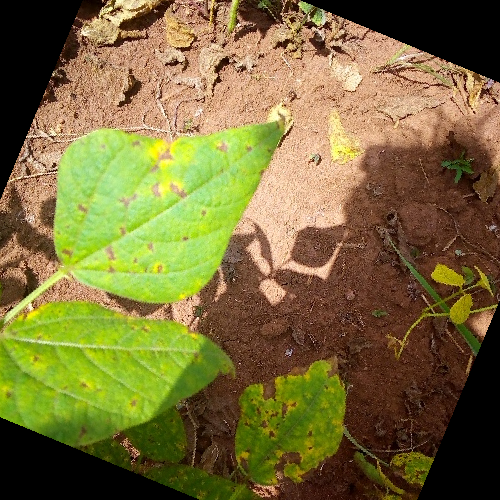

In [5]:
dataset.set_transform(transforms)
dataset[0]["pixel_values"]

**5.** これでデータセットの準備は完了です．あなたの機械学習フレームワークで学習をすることができます！